In [1]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2]:
data = pd.read_csv('file_categories.csv')  # Update the path to your CSV file

train_df, valid_df = train_test_split(data, test_size=0.2, random_state=42, stratify=data['category'])

In [3]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.3,  # Increased range
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)

In [4]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='file_name',
    y_col='category',
    target_size=(128, 128),
    batch_size=32,
    class_mode='sparse'
)

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_df,
    x_col='file_name',
    y_col='category',
    target_size=(128, 128),
    batch_size=32,
    class_mode='sparse'
)

Found 19367 validated image filenames belonging to 10 classes.
Found 4842 validated image filenames belonging to 10 classes.


In [5]:
base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(128, 128, 3)
)

for layer in base_model.layers[-4:]:
    layer.trainable = True

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [6]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    validation_data=valid_generator,
    validation_steps=valid_generator.n // valid_generator.batch_size,
    epochs=30,
    callbacks=[early_stopping, reduce_lr]
)

model.save('optimized_vgg16_animal_classifier.h5')

C:\Users\yashw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
605/605 ━━━━━━━━━━━━━━━━━━━━ 504s 829ms/step - accuracy: 0.1826 - loss: 9.4170 - val_accuracy: 0.2622 - val_loss: 3.6391 - learning_rate: 1.0000e-04
Epoch 2/30
  1/605 ━━━━━━━━━━━━━━━━━━━━ 7:34 753ms/step - accuracy: 0.1562 - loss: 3.7272

C:\Users\yashw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


605/605 ━━━━━━━━━━━━━━━━━━━━ 35s 56ms/step - accuracy: 0.1562 - loss: 3.7272 - val_accuracy: 0.2891 - val_loss: 3.6159 - learning_rate: 1.0000e-04
Epoch 3/30
605/605 ━━━━━━━━━━━━━━━━━━━━ 2421s 4s/step - accuracy: 0.3073 - loss: 3.2479 - val_accuracy: 0.4988 - val_loss: 2.2320 - learning_rate: 1.0000e-04
Epoch 4/30
605/605 ━━━━━━━━━━━━━━━━━━━━ 33s 54ms/step - accuracy: 0.5938 - loss: 2.1602 - val_accuracy: 0.4897 - val_loss: 2.2595 - learning_rate: 1.0000e-04
Epoch 5/30
605/605 ━━━━━━━━━━━━━━━━━━━━ 490s 810ms/step - accuracy: 0.5387 - loss: 2.0435 - val_accuracy: 0.6838 - val_loss: 1.4313 - learning_rate: 1.0000e-04
Epoch 6/30
605/605 ━━━━━━━━━━━━━━━━━━━━ 35s 56ms/step - accuracy: 0.5938 - loss: 1.6130 - val_accuracy: 0.6763 - val_loss: 1.4511 - learning_rate: 1.0000e-04
Epoch 7/30
605/605 ━━━━━━━━━━━━━━━━━━━━ 1379s 2s/step - accuracy: 0.6423 - loss: 1.5358 - val_accuracy: 0.7446 - val_loss: 1.1121 - learning_rate: 1.0000e-04
Epoch 8/30
605/605 ━━━━━━━━━━━━━━━━━━━━ 35s 56ms/step - accur

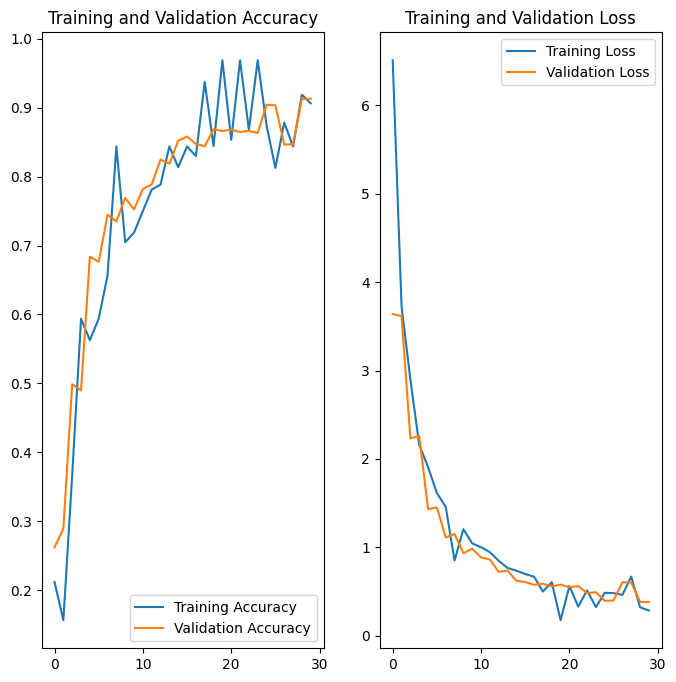

In [7]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()